# Giriş kısmı

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# Gerekli kütüphaneleri import edelim

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential,Model,model_from_json
from keras.layers import Dense , Conv2D,Activation,MaxPool2D,Flatten,Dropout,BatchNormalization
from keras.utils import np_utils
from keras.preprocessing import image as ts
from keras.callbacks import ModelCheckpoint

# Verisetimizi okuyalım

In [ ]:
data = pd.read_csv("/content/drive/My Drive/keras/verisetleri/fer2013.csv")

## Verimiz ile ilgili bazı bilgiler edinelim

In [ ]:
data.shape

(35887, 3)

35887 satır 3 tane de kolondan oluşan bir verisetimiz var

In [ ]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

Usage kolonundaki verileri saydık.Şundan şu kadar , öbüründen şu kadar var gibi

# Eğitim datası için ön işlemler

Sadece eğitim örneklerini bir değişkene atayalım.

In [ ]:
train_data = data[data.Usage == "Training"]

Eğitim örneklerinin piksel değerleri bize bir tablo halinde yan yana verildiği için boşluklardan parse edelim ve liste olarak değişkene atayalım

In [ ]:
train_pixels = train_data.pixels.str.split(" ").tolist()

bunun type'ı bir list.Şimdi de bunu dataframe yapalım

In [ ]:
train_pixels = pd.DataFrame(train_pixels,dtype=int)

In [ ]:
print(train_pixels.head())

  0    1    2    3    4    5    6     ... 2297 2298 2299 2300 2301 2302 2303
0   70   80   82   72   58   58   60  ...  136  106  116   95  106  109   82
1  151  150  147  155  148  133  111  ...  108  102   67  171  193  183  184
2  231  212  156  164  174  138  161  ...  122  114  101   97   88  110  152
3   24   32   36   30   32   23   19  ...  132  133  136  139  142  143  142
4    4    0    0    0    0    0    0  ...   31   31   27   31   30   29   30

[5 rows x 2304 columns]


2303 tane pixel var her bir fotoda

In [ ]:
train_images = train_pixels.values
print(train_images)
train_images = train_images.astype(np.float)
print(train_images)

[['70' '80' '82' ... '106' '109' '82']
 ['151' '150' '147' ... '193' '183' '184']
 ['231' '212' '156' ... '88' '110' '152']
 ...
 ['74' '81' '87' ... '188' '187' '187']
 ['222' '227' '203' ... '136' '136' '134']
 ['195' '199' '205' ... '6' '15' '38']]
[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]


Böyle bir işlem yaptık.Şimdi resmi 48*48 px şekline sokmak için bir fonksiyon tanımlayalım

In [ ]:
def show(img):
  show_image=img.reshape(48,48)
  plt.axis("off")
  plt.imshow(show_image,cmap="gray")

Bir örnek ile fonksiyonumuzu deneyelim

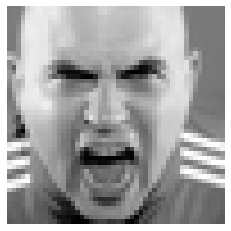

In [ ]:
show(train_images[22])

In [ ]:
train_data["emotion"].value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

Görüyoruz ki 7 tane farklı etiket var.

Şöyle de farklı şekillerde görebilirdik

In [ ]:
train_labels_flat = train_data["emotion"].values
train_labels_count = np.unique(train_labels_flat).shape[0]
print(train_labels_flat)
print(train_labels_flat.ravel())
print(np.unique(train_labels_flat))
print(np.unique(train_labels_flat).shape)
print(np.unique(train_labels_flat).shape[0])

[0 0 2 ... 4 0 4]
[0 0 2 ... 4 0 4]
[0 1 2 3 4 5 6]
(7,)
7


Şimdi etiketleri **One-Hot Encoding** yöntemi ile sınıflandıracağız/işleyeceğiz.Hatırlanmalıdır ki bu etiketler **kategorilenebilir değişken**lerdir.

In [ ]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [ ]:
y_train = dense_to_one_hot(train_labels_flat,train_labels_count)
print(y_train)
y_train = y_train.astype(np.uint8)
print(y_train)
print(y_train.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]
(28709, 7)


Eğitim/training verimizde yukarıda da belirttiğimiz gibi 28709 veri ve 7 farklı etiket vardır.

# Test datası için ön işlemler

Eğitim seti için yaptığımız işlemlerin aynısını yapacağız

In [ ]:
test_data = data[data.Usage == "PublicTest"]

In [ ]:
test_pixels = test_data.pixels.str.split(" ").tolist()
test_pixels = pd.DataFrame(test_pixels,dtype=int)
print(test_pixels.head())

  0    1    2    3    4    5    6     ... 2297 2298 2299 2300 2301 2302 2303
0  254  254  254  254  254  249  255  ...   84   22    0    0   42  129  180
1  156  184  198  202  204  207  210  ...  193  188  184  180  172  167  161
2   69  118   61   60   96  121  103  ...   90   92   93   92   88   87   90
3  205  203  236  157   83  158  120  ...  206  196  181  112   43   82   86
4   87   79   74   66   74   96   77  ...   35   38   40   45   41   34   32

[5 rows x 2304 columns]


In [ ]:
test_images = test_pixels.values
print(test_images)
test_images = test_images.astype(np.float)
print(test_images)
print(test_images.shape)

[['254' '254' '254' ... '42' '129' '180']
 ['156' '184' '198' ... '172' '167' '161']
 ['69' '118' '61' ... '88' '87' '90']
 ...
 ['255' '255' '255' ... '48' '50' '46']
 ['33' '25' '31' ... '4' '5' '4']
 ['61' '63' '59' ... '113' '165' '180']]
[[254. 254. 254. ...  42. 129. 180.]
 [156. 184. 198. ... 172. 167. 161.]
 [ 69. 118.  61. ...  88.  87.  90.]
 ...
 [255. 255. 255. ...  48.  50.  46.]
 [ 33.  25.  31. ...   4.   5.   4.]
 [ 61.  63.  59. ... 113. 165. 180.]]
(3589, 2304)


yine yukarıda belirttiğimiz gibi 3589 test verisi var ve pixeller 2303 tane

bir tane örnek gösterelim

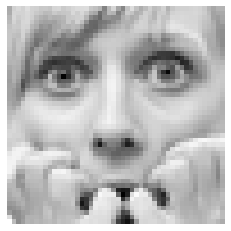

In [ ]:
show(test_images[13])

In [ ]:
test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]
y_test=dense_to_one_hot(test_labels_flat,test_labels_count)
y_test = y_test.astype(np.uint8)

print(test_labels_flat,test_labels_count,y_test,y_test.shape)

[0 1 4 ... 4 4 4] 7 [[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]] (3589, 7)


Ek olarak test verisinden bir kaç veriyi toplu halde görselleştirmeye tabi tutualım

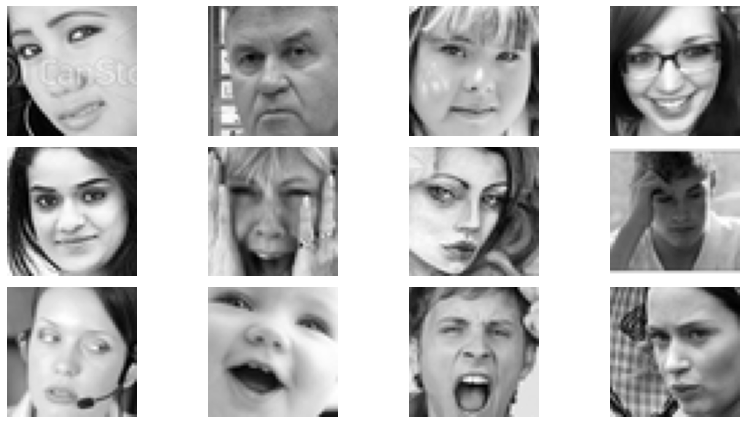

In [ ]:
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.axis('off')
    
    image = test_images[i].reshape(48,48)
    plt.imshow(image, cmap="gray")

plt.tight_layout()
plt.show()

# Modelimizi kuralım

In [ ]:
model = Sequential()

## Katman/Layer 1

In [ ]:
model.add(Conv2D(64,3,data_format="channels_last",kernel_initializer="he_normal",input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

**Batch normalization** is a technique designed to automatically standardize the inputs to a layer in a deep learning neural network.Normalize and scale inputs or activations.

Toplu normalleştirme, girdileri derin öğrenme sinir ağındaki bir katmana otomatik olarak standartlaştırmak için tasarlanmış bir tekniktir.

**Initializers** define the way to set the initial random `weights` of Keras layers.

Keras katmanlarının `ağırlıklarının` nasıl ayarlanılacağını ayarlamak için **initializers**lar kullanılır.Mesela:"random_normal","he_normal"

**data_format** ya `channel_last(default)` ya da `channel_first` olur.

`channel_last`:(batch_size,height,width,channels)

`channel_first`:(batch_size,channels,height,width)

## Katman/Layer 2

In [ ]:
model.add(Conv2D(64,3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Dropout(0.6))

##Katman/Layer 3

In [ ]:
model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation("relu"))

## Katman/Layer 4

In [ ]:
model.add(Conv2D(32,3))
model.add(BatchNormalization())
model.add(Activation("relu"))

## Katman/Layer 5

In [ ]:
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.4))

##Katman/Layer 6

In [ ]:
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.4))

## Katman/Layer 7

In [ ]:
model.add(Dense(7))
model.add(Activation("softmax"))

# Model özetine bakalım

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_7 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
activation_7 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_8 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_8 (Activation)    (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 64)       

# Modelimizi compile edelim

In [ ]:
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

**Adam optimizasyonu**, birinci dereceden ve ikinci dereceden momentlerin uyarlamalı tahminine dayanan stokastik bir gradyan iniş yöntemidir.

**Accuracy metriği** tahminlerin ne sıklıkla etiketlerle eşit olduğunu ölçer.

**categorical_crossentropy** ,etiketler ve tahminler arasında çapraz girişim kaybını hesaplar.

> **İki veya daha fazla etiket sınıfı** olduğunda bu çapraz çarpma kaybı işlevini kullanın. 

>Etiketlerin bir **`one_hot encoding`** şeklinde sunulmasını bekliyoruz . 

Etiketleri tam sayı olarak sağlamak istiyorsanız, 
lütfen `SparseCategoricalCrossentropy` kayıp kullanın





# Model eğitiminden önceki son işlemler

**Eğitim** ve **test** girdilerinin şekillerini düzenleyelim

In [ ]:
x_train =train_images.reshape(-1,48,48,1)
x_test = test_images.reshape(-1,48,48,1)

print("Train:", x_train.shape)
print("Test:", x_test.shape)

Train: (28709, 48, 48, 1)
Test: (3589, 48, 48, 1)


reshape(-1,a,b,c) kısmında
1. -1 şu demektir: gelen görüntünün boyutlarını bilmiyoruz ve numpy'dan bunu otomatik olarak algılamasını bekliyoruz.Ve numpy dizinin uzunluğuna ve kalan boyutlara bakarak bunu yapacaktır.
2. a : height
3. b : width
4. c : number of channels

In [ ]:
print("Train:", y_train.shape)
print("Test:", y_test.shape)

Train: (28709, 7)
Test: (3589, 7)


# Model eğitimi

Ekstra olarak en başarılı ağırlıkları kaydeden bir uygulama da yapacağız

In [ ]:
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/keras",verbose=1,save_best_only=True)

epochs = 10
batchsize = 100

Modeli çalıştıralım

1. **shuffle=True** : Tüm verisetini şöyle bir güzel karıştırır ve sonra belirlediğimiz batch_size'a göre batch yapar.
2. **callbacks** : Eğitimin çeşitli aşamalarında (örneğin başında , sonunda veya her bir batchin veya epochun başında,sonunda) eylemler gerçekleştirebilen bir nesnedir. 

Ayrıca modelimizi bir json dosyası olarak kaydedelim.

In [ ]:
hist = model.fit(x_train,y_train,
                 epochs=epochs,
                 batch_size=batchsize,
                 verbose=2,
                 callbacks=[checkpointer],
                 shuffle=True,
                 validation_data=(x_test,y_test))
model_json = model.to_json()
with open("/content/drive/My Drive/keras/face_model.json","w") as json_file:
  json_file.write(model_json)

Epoch 1/10

Epoch 00001: val_loss improved from 1.13957 to 1.13513, saving model to /content/drive/My Drive/keras
INFO:tensorflow:Assets written to: /content/drive/My Drive/keras/assets
288/288 - 8s - loss: 1.1300 - accuracy: 0.5694 - val_loss: 1.1351 - val_accuracy: 0.5704
Epoch 2/10

Epoch 00002: val_loss improved from 1.13513 to 1.11811, saving model to /content/drive/My Drive/keras
INFO:tensorflow:Assets written to: /content/drive/My Drive/keras/assets
288/288 - 8s - loss: 1.1107 - accuracy: 0.5776 - val_loss: 1.1181 - val_accuracy: 0.5681
Epoch 3/10

Epoch 00003: val_loss improved from 1.11811 to 1.11716, saving model to /content/drive/My Drive/keras
INFO:tensorflow:Assets written to: /content/drive/My Drive/keras/assets
288/288 - 7s - loss: 1.0937 - accuracy: 0.5855 - val_loss: 1.1172 - val_accuracy: 0.5762
Epoch 4/10

Epoch 00004: val_loss did not improve from 1.11716
288/288 - 5s - loss: 1.0798 - accuracy: 0.5918 - val_loss: 1.1232 - val_accuracy: 0.5704
Epoch 5/10

Epoch 00005

# Eğitim sonrası

Model işlemlerini biraz görselleştirelim

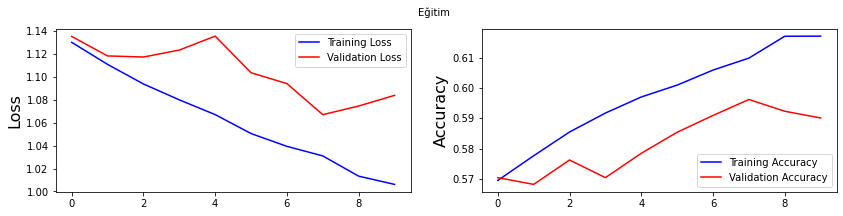

In [ ]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Modelimiz pek de iyi değil.

#Daha sonra

Model Kaggle'da train test bir de özel test denilen **private test**'e tabi tutulur. Onu deneyelim.

In [ ]:
test = data[["emotion","pixels"]][data["Usage"] =="PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im,sep=" "))
test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


Buradaki **lambda** der ki: test datasındaki pixels kolonunun her bir elemanına uygula (neyi uygula): her bir elemanı al ve seperate et (nerelerinden): " " bu şekil seperate et.

In [ ]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private =np.array(test["emotion"])

x_test_private için vstack yaptık ama hstack de yapabilirdik.

In [ ]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

 np_utils.to_categorical : Bir sınıf vektörünü (tamsayılar) ikili sınıf matrisine dönüştürür.

 utilities :araçlar demektir zaten

Şimdi Private set için skor bulalım

In [ ]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print("PrivateTest üzerinde doğruluk başarımı:", score)

PrivateTest üzerinde doğruluk başarımı: [1.0541791915893555, 0.6021175980567932]


# Kendi deneğimizle test edelim

In [ ]:
test_img_path = "/content/drive/My Drive/keras/resimler/kemalsunal.jpg"

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


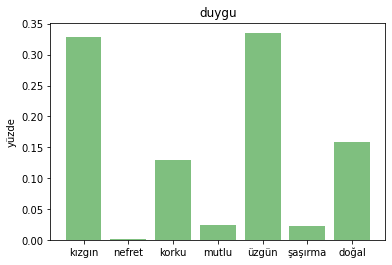

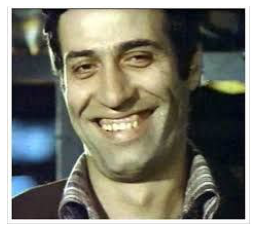

In [ ]:
img_orj = ts.load_img(test_img_path)
img = ts.load_img(test_img_path, grayscale=True, target_size=(48, 48))

x = ts.img_to_array(img)
x = np.expand_dims(x,axis=0)
x/=255
custom = model.predict(x)

#1
objects = ('kızgın', 'nefret', 'korku', 'mutlu', 'üzgün', 'şaşırma', 'doğal')
y_pos = np.arange(len(objects))
    
plt.bar(y_pos, custom[0], align='center', alpha=0.5, color='g')
plt.xticks(y_pos, objects)
plt.ylabel('yüzde')
plt.title('duygu')
plt.show()

#2
x = np.array(x, 'float32')
x = x.reshape([48, 48]);
plt.axis('off')
plt.gray()
plt.imshow(img_orj)

plt.show()

Model kötü olduğu için sonuçlar da pek iyi olmadı